# Модель долгосрочного погашения

<details>
<table align=left border="1">
<tr><td style="color:maroon;text-align:center;text-size:10;font-weight:bold">Загружаем из-вне</td><td style="color:maroon;text-align:center;text-size:10;font-weight:bold">Загружаем и считаем</td><td style="color:maroon;text-align:center;text-size:10;font-weight:bold">Считаем</td></tr>
<tr><td style="vertical-align:top">
    <table> 
    <tr><td style="color:navy;text-align:center;text-size:9">Переменная</td><td style="color:navy;text-align:center;text-size:9">Значение</td></tr> 
    <tr><td style="text-align:left;font-weight:bold">CPIAv</td><td style="text-align:left">ИПЦ, в среднем за год</td></tr>
    <tr><td style="text-align:left;font-weight:bold">LevelRate</td><td style="text-align:left">Уровень реальных ставок)</td></tr>
    <tr><td style="text-align:left;font-weight:bold">loan_rate</td><td style="text-align:left">Средняя ставка по выданным ипотечным ссудам, %</td></tr>
    <tr><td style="text-align:left;font-weight:bold">p_MortgLifeAv_x</td><td style="text-align:left">Средний срок выданных ипотечных ссуд, лет</td></tr>
    <tr><td style="text-align:left;font-weight:bold">loans_and_ref_vol_MKD</td><td style="text-align:left">Объем выданных ипотечных ссуд, млн. руб.</td></tr>
    </table>
</td><td style="vertical-align:top">
    <table> 
    <tr><td style="color:navy;text-align:center;text-size:9">Переменная</td><td style="color:navy;text-align:center;text-size:9">Значение</td></tr> 
    <tr><td style="text-align:left;font-weight:bold">CPR</td><td style="text-align:left">Модель: Досрочные погашения</td></tr>
    </table>
</td>
    <td style="vertical-align:top">
<table> 
    <tr><td style="color:navy;text-align:center;text-size:9">Переменная</td><td style="color:navy;text-align:center;text-size:9">Значение</td></tr> 
    <tr><td style="text-align:left;font-weight:bold">PMT</td><td style="text-align:left">Сумма периодического платежа для аннуитета на основе постоянства сумм платежей и постоянной процентной ставки</td></tr>
    </table>
    </td></tr>
</table>
</details>

In [1]:
from IPython.display import Markdown as md
import pandas as pd
import numpy as np

import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats.mstats import gmean 
from datetime import datetime as dt

%run ../COMMON/common.ipynb # загрузка общих функций и констант, все, что оттуда, должно иметь префикс common.

from source_data.src import db_source, RowTypes
import source_data.prepare as prep

iFirstFactYear=2008
iLastFactYear=2018

iFirstForecastYear=iLastFactYear+1
iLastForecastYear=2030

In [2]:
# strU='UPDATE headers SET code2="LevelRate" where code=239'

# with conWork.connect() as connection:
#     result = connection.execute(strU)

In [2]:
class repay_e:
    pdfWork=None
    
    lstYearCodes=['CPIAv', 'LevelRate', 'loan_rate', 'p_MortgLifeAv_x', 'loans_and_ref_vol_MKD', 'CPR'] # список экзогенных и фактических данных
 
    def __init__(self):
        assert False, 'you can\'t create variables of repay_e class!'
    
    def MakeWorkFrame():
        ''' Загрузка исходных данных
            Исходные данные:
                Фактические значения - из базы данных year.sqlite3;
                Экзогенные - из базы данных exog_year.sqlite3
                Задаваемые вручную - из базы данных exog_param.sqlite3
                Результаты других моделей - из базы данных svod.sqlite3. 
        '''
        
        srcAct = db_source(common.strYearDBPath, RowTypes.FACT, repay_e.lstYearCodes)
        srcAct.prepare=[{'func':prep.scale, 'list_fields':['LevelRate', 'loan_rate', 'CPR'], 'param':100},
                        {'func':prep.scale, 'list_fields':['loans_and_ref_vol_MKD',],        'param':1e6}]
        
        srcExog = db_source(common.strExYearDBPath, RowTypes.EXOG_R, repay_e.lstYearCodes)
        srcExog.prepare={'func':prep.scale, 'list_fields':['LevelRate',], 'param':100}
        
        srcExogP = db_source(common.strExParamDBPath, RowTypes.EXOG_P, repay_e.lstYearCodes)

        srcSvod  = db_source(common.strSvodDBPath, RowTypes.MODEL, repay_e.lstYearCodes)
        srcSvod.prepare={'func':prep.scale, 'list_fields':['loans_and_ref_vol_MKD',], 'param':1e6}
        
        repay_e.pdfWork=common.combine_frames(srcAct, srcExog, srcExogP, srcSvod)

        
#         lstFrms=[x.make_frame() for x in [srcAct, srcExog, srcExogP, srcSvod]]
        
#         repay_e.pdfWork=lstFrms[0].combine_first(lstFrms[1]).combine_first(lstFrms[2]).combine_first(lstFrms[3])
        
        repay_e.pdfWork['pmt'] =  np.pmt(repay_e.pdfWork['loan_rate'] / 1200, 
                                         repay_e.pdfWork['p_MortgLifeAv_x']*12, 
                                         -repay_e.pdfWork['loans_and_ref_vol_MKD'])
        return repay_e.pdfWork

In [3]:
repay_e.MakeWorkFrame().sort_index()

,CPIAv,CPR,LevelRate,loan_rate,loans_and_ref_vol_MKD,p_MortgLifeAv_x,pmt
date,,,,,,,
2004,1.108812,NaN,2.638760,NaN,1.850000e+04,NaN,NaN
2005,1.127055,NaN,0.274468,14.900000,5.634100e+04,14.550000,791.320598
2006,1.096830,NaN,-0.788789,13.700000,2.635610e+05,NaN,NaN
2007,1.089881,NaN,-1.475535,12.600000,5.564890e+05,NaN,NaN
2008,1.141048,11.127132,-5.975708,12.900000,6.558080e+05,17.941667,7833.664403
2009,1.116977,11.014075,-0.387689,14.300000,1.525010e+05,16.458333,2011.100001
2010,1.068508,10.625308,1.179214,13.100000,3.800610e+05,16.358333,4707.707311
2011,1.084634,12.224180,-0.343393,11.900000,7.169440e+05,14.908333,8577.537766
2012,1.050667,11.408883,3.003275,12.290000,1.031992e+06,14.958333,12591.056712


## Промежуточные расчеты

Для каждого года расчитываем подфрейм длительности процедуры погашения поколений ипотечных кредитов:
  - \_prc
  - \_notional	
  - \_ntl	
  - \_debt	
  - \_cpr

Для у - год расчета подфрейма, i - месяц внутри подфрейма   

$
\begin{equation*}
    \_prc_{y,i} =  
     \begin{cases}
       \frac{\large loans\_and\_ref\_vol\_MKD_y * loan\_rate_y}{\large 1200} \quad ; \quad \text{при i=0} \\
       \frac{\large \_debt_{y, i-1} * loan\_rate_y}{\large 1200} \quad ; \quad \text{при i>0} 
     \end{cases}
\end{equation*}
$  

$\_notional_{y, i} = PMT_y - \_prc_{y, i}  $

$
\begin{equation*}
    \_ntl_{y, i} =  
     \begin{cases}
       loans\_and\_ref\_vol\_MKD_y \quad ; \quad \text{при i=0} \\
       \_debt_{y, i-1} - \_notional_{y, i} \quad ; \quad \text{при i>0} 
     \end{cases}
\end{equation*}
$  


$
\begin{equation*}
    \_debt_{y,i} =  
     \begin{cases}
       \_ntl_{y, i} - \_cpr_{y, i} \quad ; \quad \text{при } \_debt_{y, i} > 0 \\
       0 \quad ; \quad \text{при } \_debt_{y, i} <= 0 
     \end{cases}
\end{equation*}
$  


$
\begin{equation*}
    \_cpr_{y,i} =  
     \begin{cases}
       MIN\left( \_ntl_{y, i} * \left(1 + \frac{PMT_y}{100} \right)^{\frac{1}{12}} - 1, \quad \_ntl_{y, i} \right) \quad \text{при } \_cpr_{y, i} > 0 \\
       0 \quad ; \quad \text{при } \_cpr_{y, i} <= 0
     \end{cases}
\end{equation*}
$   

**для каждого года расчет выполняется до полногосписания долга, то есть до:**   $ \_debt_{y, i}=0$

**В дальнейших расчетах используются данные долга (debt) этих фреймов, усредненные по годам ( $ AverageFrame_{y, i} $)** где y - год, на который расчитывался фрейм, и i - год внутри фрейма.
Например, фрейм расчитан на 2008 год, внутри фрейма нам нужен 2010 год - $ AverageFrame_{2008, 2010} $

In [4]:
class _rgml():
    """класс погашения поколений ипотечных кредитов"""
    
    def __init__(self, year_data:pd.Series):
        self._cprpow = (1+year_data['CPR']/100) ** (1/12) - 1
        self._loan_rate_corr=year_data['loan_rate'] / 1200
        self._pmt=year_data['pmt']
        self._debt=[year_data['loans_and_ref_vol_MKD'],]
        self._prc =[0]
        self._notional=[0 ]

        self._ntl=[ 0]
        self._cpr=[0]
        self._year=year_data.name
        self._pdf=self.calc_frame().groupby(pd.Grouper(level=0, freq="Y"))[['debt', 'cpr']].mean()
        
    def print(self):
        print('debt=', len(self._debt))
        print('prc=', len(self._prc))
        print('notional=', len(self._notional))
        print('ntl=', len(self._ntl))
        print('cpr=', len(self._cpr))

    def _calc_cpr(self, ntl):
        return min( ntl * self._cprpow, ntl)
        
    def _calc_prc(self, debt_1):
        return debt_1 * self._loan_rate_corr

    def _calc_ntl(self, debt_1, notional):
        return debt_1 - notional

    def _calc_notional(self, prc):
        return self._pmt-prc

    def _step(self, i):
#         print(i)
        self._prc.append(self._calc_prc(self._debt[i-1]))
        self._notional.append(self._calc_notional(self._prc[-1]))
        self._ntl.append(self._calc_ntl(self._debt[i-1], self._notional[-1]))
        self._cpr.append(self._calc_cpr(self._ntl[-1]))
        self._debt.append(self._ntl[-1] - self._cpr[-1])
#         self.print()

    
    def calc_frame(self):
        i=1
        while self._debt[-1]>0:
            self._step(i)
            i+=1
        self._pdf = pd.DataFrame({'debt':self._debt, 'cpr':self._cpr, 'prc':self._prc, 'notional':self._notional}).iloc[1:-1]

        self._pdf.index=pd.date_range(dt.date(self._year, 1, 1), periods=self._pdf.shape[0], freq='MS')
        self._pdf.index.name='date'
        return self._pdf
    
    @property
    def Frame(self):
        return self._pdf
    
    @property
    def AverageFrame(self):
#         return self._pdf.groupby(pd.Grouper(level=0, freq="Y"))[['debt', 'cpr']].mean()
        return self.Frame

    def AverageYear(self, iYear):
        if self._year>iYear: return 0
#         print(_pdf)
        try:
#             return self._pdf.loc[_pdf.index.year==iYear, 'debt'].values[0]
            return self._pdf.loc[self._pdf.index.year == iYear, 'debt'].values[0]
        except (IndexError, KeyError):
            return 0
    
_rgml_dic={repay_e.pdfWork.loc[y].name: _rgml(repay_e.pdfWork.loc[y]) for y in range(iFirstFactYear, iFirstForecastYear)}
# _rgml_dic

## Расчет предикторов модели
  1. ИПЦ, среднегеом. (_IPCgeo)  
$$ \_IPCgeo = \left( \prod _{i=y-5}^{y} CPIAv_{i}  \right)^{\frac {1}{n}} $$

для расчета предиктора используется производная величина: $ \_XIPCgeo = \frac{1}{\_IPCgeo}$

  2. Средневзвешенная ставка по портфелю ипотечных ссуд (_waropml)
$$ 
\begin{equation*}
    \_waropml_y = 
    \begin{cases}
       loan\_rate_y \quad \text{при y=iFirstFactYear} \\ \\
       \large {\frac{loan\_rate_y * loans\_and\_ref\_vol\_MKD_y}{loans\_and\_ref\_vol\_MKD_y + \sum_{i=iFirstFactYear}^{y-1} \, \_rgml_i.AveragFrame_{y-1}} + \\ \sum_{i=iFirstFactYear+1}^{y-1}  \frac{loan\_rate_{i} * \_rgml_{i}.AveragFrame_{y-1}}{loans\_and\_ref\_vol\_MKD_y + \sum_{i=iFirstFactYear}^{y-1} \, \_rgml_i.AveragFrame_{i, y-1}} }
       \quad \small \text{при iFirstFactYear < y <= iLastFactYear} 
        \end{cases}
\end{equation*}
$$

In [5]:
repay_e.pdfWork['_IPCgeo']=repay_e.pdfWork['CPIAv'].rolling(5).apply(gmean)
repay_e.pdfWork['_XIPCgeo']=1/repay_e.pdfWork['_IPCgeo']

def _calc_waropml_x1(x):
    _x1=((x['loan_rate'] * x['loans_and_ref_vol_MKD']) / 
         (x['loans_and_ref_vol_MKD'] + _calc_year_average(x)))
    return _x1

def _calc_year_average(x):
    y = x if type(x)!=pd.Series else x.name
    return sum([_rgml_dic[i].AverageYear(y-1) for i in range(iFirstFactYear, y)])

def _calc_waropml_x2(x):
    _x1=((x['loan_rate'] * _rgml_dic[x.name].AverageYear(x.name)) / 
        (x['loans_and_ref_vol_MKD'] + x['_sum_year_average']))
    return _x1

def _calc_wrpml_y(x):
    lrf=repay_e.pdfWork.loc[x, 'loans_and_ref_vol_MKD']
    x2=sum([(repay_e.pdfWork.loc[i, 'loan_rate'] * _rgml_dic[i].AverageYear(x-1)) / (lrf + repay_e.pdfWork.loc[x, '_sum_year_average']) for i in range(iFirstFactYear, x)])
    return repay_e.pdfWork.loc[x, '_waropml_x1'] + x2

repay_e.pdfWork.loc[iFirstFactYear:iFirstForecastYear, '_sum_year_average'] =  repay_e.pdfWork.loc[iFirstFactYear:iFirstForecastYear].apply(_calc_year_average, axis=1)
repay_e.pdfWork.loc[iFirstFactYear:iFirstForecastYear, '_waropml_x1'] =  repay_e.pdfWork.loc[iFirstFactYear:iFirstForecastYear].apply(_calc_waropml_x1, axis=1)
repay_e.pdfWork.loc[iFirstFactYear:iFirstForecastYear, '_waropml']=([repay_e.pdfWork.loc[iFirstFactYear, 'loan_rate']] + 
                                                               [_calc_wrpml_y(y) for y in range(iFirstFactYear+1, iFirstForecastYear+1)])


repay_e.pdfWork

,CPIAv,CPR,LevelRate,loan_rate,loans_and_ref_vol_MKD,p_MortgLifeAv_x,pmt,_IPCgeo,_XIPCgeo,_sum_year_average,_waropml_x1,_waropml
date,,,,,,,,,,,,
2004,1.108812,NaN,2.638760,NaN,1.850000e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005,1.127055,NaN,0.274468,14.900000,5.634100e+04,14.550000,791.320598,NaN,NaN,NaN,NaN,NaN
2006,1.096830,NaN,-0.788789,13.700000,2.635610e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007,1.089881,NaN,-1.475535,12.600000,5.564890e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008,1.141048,11.127132,-5.975708,12.900000,6.558080e+05,17.941667,7833.664403,1.112564,0.898824,0.000000e+00,12.900000,12.900000
2009,1.116977,11.014075,-0.387689,14.300000,1.525010e+05,16.458333,2011.100001,1.114198,0.897507,6.128283e+05,2.849446,13.178967
2010,1.068508,10.625308,1.179214,13.100000,3.800610e+05,16.358333,4707.707311,1.102374,0.907133,6.747359e+05,4.720150,13.161161
2011,1.084634,12.224180,-0.343393,11.900000,7.169440e+05,14.908333,8577.537766,1.099911,0.909164,9.287642e+05,5.184172,12.612582
2012,1.050667,11.408883,3.003275,12.290000,1.031992e+06,14.958333,12591.056712,1.091880,0.915852,1.440855e+06,5.128980,12.461264


  3. Средневзвешенный срок до погашения по портфелю ипотечных ссуд (_wadrpml)   
  
  $$ 
\begin{equation*}
    \_wadrpml_y = 
    \begin{cases}
       p\_MortgLifeAv\_x_y \quad \text{при y=iFirstFactYear} \\ \\
       \large {\frac{p\_MortgLifeAv\_x_y * loans\_and\_ref\_vol\_MKD_y}{loans\_and\_ref\_vol\_MKD_y + \sum_{i=iFirstFactYear}^{y-1} \, \_rgml_i.AveragFrame_{y-1}} + \\ \sum_{i=iFirstFactYear+1}^{y-1}  \frac{ (p\_MortgLifeAv\_x_{i} - i+iFirstFactYear) * \_rgml_{i}.AveragFrame_{y-1}}{loans\_and\_ref\_vol\_MKD_y + \sum_{i=iFirstFactYear}^{y-1} \, \_rgml_i.AveragFrame_{i, y-1}} }
       \quad \small \text{при iFirstFactYear < y <= iLastFactYear} 
        \end{cases}
\end{equation*}
$$

In [6]:
def _calc_wadrpml_x2(y, cnst):
    _x1=0
    
    xl=cnst + sum([_rgml_dic[i].AverageYear(y-1) for i in range(iFirstFactYear, y)])
    
    for j, _y in enumerate(range(y-1, iFirstFactYear-1, -1)):
        xu= (repay_e.pdfWork.loc[_y, 'p_MortgLifeAv_x'] - (j+1) ) * _rgml_dic[_y].AverageYear(y-1)
        _x1 += xu / xl

    return _x1

def _calc_wadrpml(y):
    lrf=repay_e.pdfWork.loc[y, 'loans_and_ref_vol_MKD']
    xw=repay_e.pdfWork.loc[y, :]
    
    x1=(xw['p_MortgLifeAv_x'] * xw['loans_and_ref_vol_MKD']) / (xw['loans_and_ref_vol_MKD'] + sum([_rgml_dic[i].AverageYear(y-1) for i in range(iFirstFactYear, y)]))
    x2= _calc_wadrpml_x2(y, lrf)

    return x1 + x2 

 
repay_e.pdfWork.loc[iFirstFactYear, '_wadrpml']=repay_e.pdfWork.loc[iFirstFactYear, 'p_MortgLifeAv_x']
repay_e.pdfWork.loc[iFirstFactYear+1:iFirstForecastYear, '_wadrpml']=[_calc_wadrpml(y) for y in range(iFirstFactYear+1, iFirstForecastYear+1)]


repay_e.pdfWork

,CPIAv,CPR,LevelRate,loan_rate,loans_and_ref_vol_MKD,p_MortgLifeAv_x,pmt,_IPCgeo,_XIPCgeo,_sum_year_average,_waropml_x1,_waropml,_wadrpml
date,,,,,,,,,,,,,
2004,1.108812,NaN,2.638760,NaN,1.850000e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005,1.127055,NaN,0.274468,14.900000,5.634100e+04,14.550000,791.320598,NaN,NaN,NaN,NaN,NaN,NaN
2006,1.096830,NaN,-0.788789,13.700000,2.635610e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007,1.089881,NaN,-1.475535,12.600000,5.564890e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008,1.141048,11.127132,-5.975708,12.900000,6.558080e+05,17.941667,7833.664403,1.112564,0.898824,0.000000e+00,12.900000,12.900000,17.941667
2009,1.116977,11.014075,-0.387689,14.300000,1.525010e+05,16.458333,2011.100001,1.114198,0.897507,6.128283e+05,2.849446,13.178967,16.845357
2010,1.068508,10.625308,1.179214,13.100000,3.800610e+05,16.358333,4707.707311,1.102374,0.907133,6.747359e+05,4.720150,13.161161,16.026515
2011,1.084634,12.224180,-0.343393,11.900000,7.169440e+05,14.908333,8577.537766,1.099911,0.909164,9.287642e+05,5.184172,12.612582,14.980855
2012,1.050667,11.408883,3.003275,12.290000,1.031992e+06,14.958333,12591.056712,1.091880,0.915852,1.440855e+06,5.128980,12.461264,14.388784


### Предиктор - Средневзвешенный (по сроку до погашения) объем процентных платежей (от величины портфеля) - \_wamvipp

$$ \_wamvipp = \frac{\_waropml * \left( 1 - \_XIPCgeo^{\_wadrpml} \right)}{1-\_XIPCgeo} $$
  

In [9]:
repay_e.pdfWork['_wamvipp']=(repay_e.pdfWork['_waropml'] * 
                             (1 - (repay_e.pdfWork['_XIPCgeo']**repay_e.pdfWork['_wadrpml'])) /  (1-repay_e.pdfWork['_XIPCgeo']))
repay_e.pdfWork

,CPIAv,CPR,LevelRate,loan_rate,loans_and_ref_vol_MKD,p_MortgLifeAv_x,pmt,_IPCgeo,_XIPCgeo,_sum_year_average,_waropml_x1,_waropml,_wadrpml,_wamvipp
date,,,,,,,,,,,,,,
2004,1.108812,NaN,2.638760,NaN,1.850000e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005,1.127055,NaN,0.274468,14.900000,5.634100e+04,14.550000,791.320598,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006,1.096830,NaN,-0.788789,13.700000,2.635610e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2007,1.089881,NaN,-1.475535,12.600000,5.564890e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008,1.141048,11.127132,-5.975708,12.900000,6.558080e+05,17.941667,7833.664403,1.112564,0.898824,0.000000e+00,12.900000,12.900000,17.941667,108.692208
2009,1.116977,11.014075,-0.387689,14.300000,1.525010e+05,16.458333,2011.100001,1.114198,0.897507,6.128283e+05,2.849446,13.178967,16.845357,107.782377
2010,1.068508,10.625308,1.179214,13.100000,3.800610e+05,16.358333,4707.707311,1.102374,0.907133,6.747359e+05,4.720150,13.161161,16.026515,112.000991
2011,1.084634,12.224180,-0.343393,11.900000,7.169440e+05,14.908333,8577.537766,1.099911,0.909164,9.287642e+05,5.184172,12.612582,14.980855,105.509793
2012,1.050667,11.408883,3.003275,12.290000,1.031992e+06,14.958333,12591.056712,1.091880,0.915852,1.440855e+06,5.128980,12.461264,14.388784,106.282033


### Добавляем дамми - \_D1 и \_D2

In [10]:
repay_e.pdfWork['_D1']=0
repay_e.pdfWork.loc[2015, '_D1']=1

repay_e.pdfWork['_D2']=0
repay_e.pdfWork.loc[(2017, 2018), '_D2']=1

repay_e.pdfXY=repay_e.pdfWork[['CPR', '_wamvipp', '_D1', '_D2']]
repay_e.pdfXY

,CPR,_wamvipp,_D1,_D2
date,,,,
2004,NaN,NaN,0,0
2005,NaN,NaN,0,0
2006,NaN,NaN,0,0
2007,NaN,NaN,0,0
2008,11.127132,108.692208,0,0
2009,11.014075,107.782377,0,0
2010,10.625308,112.000991,0,0
2011,12.224180,105.509793,0,0
2012,11.408883,106.282033,0,0


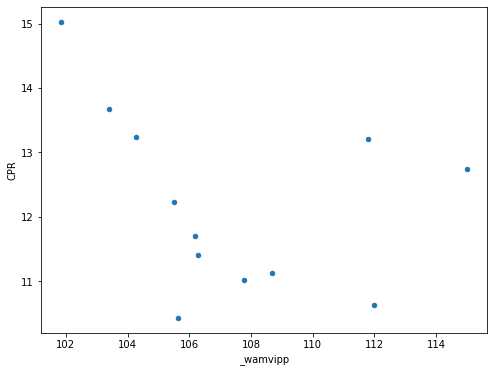

In [11]:
repay_e.pdfXY.plot.scatter('_wamvipp', 'CPR', figsize=(8, 6));

## Оценка модели

$$ \large CPR \sim \_wamvipp + \_D1 + \_D2 $$

In [12]:
resDP = smf.ols(formula='CPR ~ _wamvipp + _D1 + _D2 - 1', missing='drop', data=repay_e.pdfXY).fit()
print(resDP.summary())

                                 OLS Regression Results                                
Dep. Variable:                    CPR   R-squared (uncentered):                   0.995
Model:                            OLS   Adj. R-squared (uncentered):              0.993
Method:                 Least Squares   F-statistic:                              546.9
Date:                Fri, 19 Mar 2021   Prob (F-statistic):                    1.69e-10
Time:                        19:26:04   Log-Likelihood:                         -15.852
No. Observations:                  12   AIC:                                      37.70
Df Residuals:                       9   BIC:                                      39.16
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [13]:
resDP.params

_wamvipp    0.109650
_D1        -1.157135
_D2         3.103010
dtype: float64

# Расчет прогнозных значений

Расчет идет по одной точке. Сначала считаем значение CPR на текущий прогнозный год, потом считаем соотв. _подфрейм длительности процедуры погашения поколений ипотечных кредитов_, потом считаем предикторы модели на следующий прогнозный год

In [14]:
i=iFirstForecastYear

In [26]:
def _calc_waropml_x1_t(x):
    _x1=((x['loan_rate'] * x['loans_and_ref_vol_MKD']) / 
         (x['loans_and_ref_vol_MKD'] + _calc_year_average(x)))
    return _x1

def _calc_waropml_x2(x):
    _x1=((x['loan_rate'] * _rgml_dic[x.name].AverageYear(x.name)) / 
        (x['loans_and_ref_vol_MKD'] + x['_sum_year_average']))
    return _x1

def _calc_wrpml_y(x):
    lrf=repay_e.pdfWork.loc[x, 'loans_and_ref_vol_MKD']
    x2=sum([(repay_e.pdfWork.loc[i, 'loan_rate'] * _rgml_dic[i].AverageYear(x-1)) / (lrf + repay_e.pdfWork.loc[x, '_sum_year_average']) for i in range(iFirstFactYear, x)])
    return repay_e.pdfWork.loc[x, '_waropml_x1'] + x2

def _calc_wamvip(x):
    _x=repay_e.pdfWork.loc[x]
    return _x['_waropml'] *  (1 - (_x['_XIPCgeo']**_x['_wadrpml'])) /  (1-_x['_XIPCgeo'])
    

def _calc_pmt(x):
    _x=repay_e.pdfWork.loc[x]
    return np.pmt(_x['loan_rate'] / 1200, _x['p_MortgLifeAv_x']*12, _x['loans_and_ref_vol_MKD'])
    

# repay_e.pdfWork.loc[i, 'pmt'] =  _calc_pmt(i)
_rgml_dic.setdefault(i, _rgml(repay_e.pdfWork.loc[i]))

repay_e.pdfWork.loc[i, '_sum_year_average'] =  _calc_year_average(i)
repay_e.pdfWork.loc[i, '_waropml_x1'] =  _calc_waropml_x1_t(repay_e.pdfWork.loc[i])

repay_e.pdfWork.loc[i, '_waropml']= _calc_wrpml_y(i)
repay_e.pdfWork.loc[i, '_wadrpml']=_calc_wadrpml(i)
repay_e.pdfWork.loc[i, '_wamvipp']=_calc_wamvip(i)


repay_e.pdfWork.loc[i, 'CPR']=(resDP.params['_wamvipp']*repay_e.pdfWork.loc[i, '_wamvipp'] + 
                               resDP.params['_D1']*repay_e.pdfWork.loc[i, '_D1'] + 
                               resDP.params['_D2']*repay_e.pdfWork.loc[i, '_D2'])

print(_calc_waropml_x1_t(repay_e.pdfWork.loc[i]), 
      repay_e.pdfWork.loc[iFirstFactYear, 'loan_rate'] + _calc_wrpml_y(i), _calc_wadrpml(i))

i+=1
print(i)
repay_e.pdfWork[['LevelRate', 'pmt', 'p_MortgLifeAv_x', 'loans_and_ref_vol_MKD' , 'CPR', '_waropml', '_wadrpml', '_wamvipp', '_D1', '_D2']]

7.406899610610296 20.306899610610294 24.999999999999996
2031


,LevelRate,pmt,p_MortgLifeAv_x,loans_and_ref_vol_MKD,CPR,_waropml,_wadrpml,_wamvipp,_D1,_D2
date,,,,,,,,,,
2004,2.638760,NaN,NaN,1.850000e+04,NaN,NaN,NaN,NaN,0,0
2005,0.274468,791.320598,14.550000,5.634100e+04,NaN,NaN,NaN,NaN,0,0
2006,-0.788789,NaN,NaN,2.635610e+05,NaN,NaN,NaN,NaN,0,0
2007,-1.475535,NaN,NaN,5.564890e+05,NaN,NaN,NaN,NaN,0,0
2008,-5.975708,7833.664403,17.941667,6.558080e+05,11.127132,12.900000,17.941667,108.692208,0,0
2009,-0.387689,2011.100001,16.458333,1.525010e+05,11.014075,13.178967,16.845357,107.782377,0,0
2010,1.179214,4707.707311,16.358333,3.800610e+05,10.625308,13.161161,16.026515,112.000991,0,0
2011,-0.343393,8577.537766,14.908333,7.169440e+05,12.224180,12.612582,14.980855,105.509793,0,0
2012,3.003275,12591.056712,14.958333,1.031992e+06,11.408883,12.461264,14.388784,106.282033,0,0


In [29]:
help(excel_source)

NameError: name 'excel_source' is not defined